In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.concat(pd.read_excel('online_retail_II.xlsx', sheet_name=None), ignore_index=True)

In [3]:
df.shape

(1067371, 8)

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [6]:
df.nunique(axis=0)

Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate    47635
Price           2807
Customer ID     5942
Country           43
dtype: int64

In [7]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [8]:
df_price = df[(df['Price']>0)]
df_quantity = df_price[(df_price['Quantity']>0)]

In [9]:
df_quantity.describe()

,Quantity,Price,Customer ID
count,1.041671e+06,1.041671e+06,805549.000000
mean,1.096345e+01,4.077038e+00,15331.954970
std,1.265149e+02,5.144898e+01,1696.737039
min,1.000000e+00,1.000000e-03,12346.000000
25%,1.000000e+00,1.250000e+00,13982.000000
50%,3.000000e+00,2.100000e+00,15271.000000
75%,1.000000e+01,4.130000e+00,16805.000000
max,8.099500e+04,2.511109e+04,18287.000000


In [10]:
df_quantity.shape

(1041671, 8)

In [11]:
df_quantity.isnull().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236122
Country             0
dtype: int64

In [12]:
df_na = df_quantity.dropna(axis=0)

In [13]:
df_na.shape

(805549, 8)

In [14]:
len(df_na[df_na.duplicated()])

26124

In [15]:
df_na.drop(df_na[df_na.duplicated()].index, axis=0, inplace=True)

/Users/mohamedabdallah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
df_na=df_na[['Customer ID','InvoiceDate','Invoice','Quantity','Price']]

In [17]:
df_clean= df_na[~df_na["Invoice"].astype(str).str.contains("C", na=False)]

In [18]:
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

In [104]:
df_clean.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalPrice
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.4
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.8
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.0


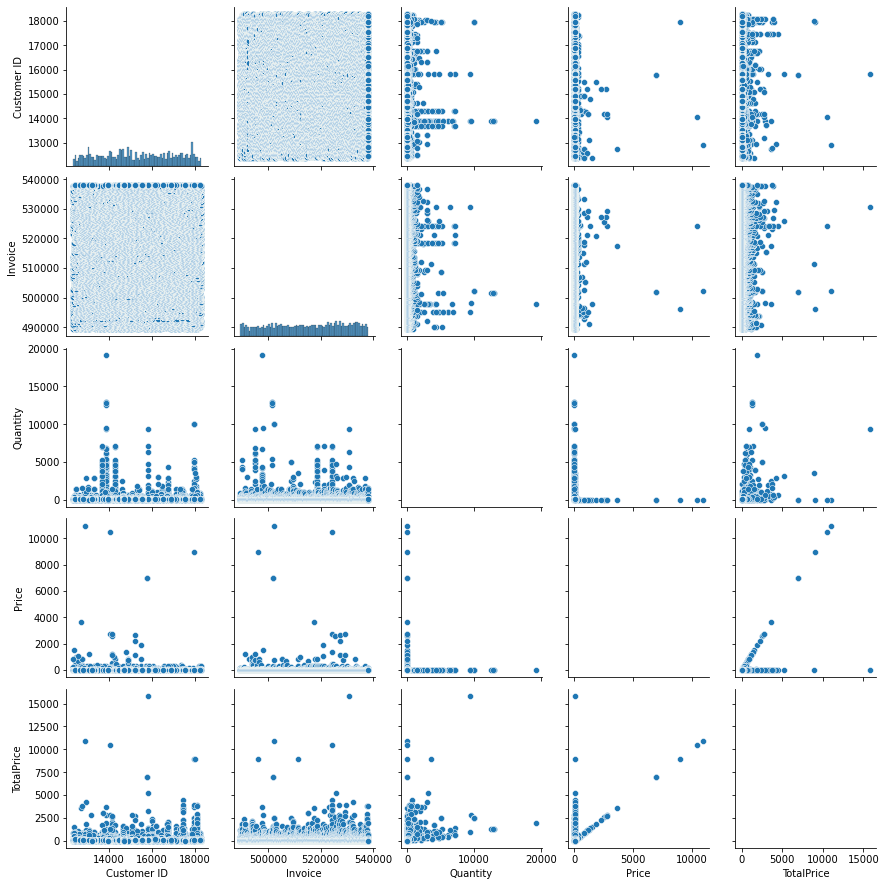

In [105]:
sns.pairplot(df_clean)

<AxesSubplot:>

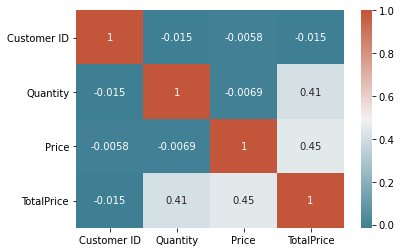

In [106]:
corr = df_clean.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [19]:
df_clean_group=df_clean.groupby('Customer ID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'Invoice': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPrice': lambda price: price.sum()})

In [20]:
df_clean_group.columns=['num_days','num_transactions','num_units','spent_money']
df_clean_group.head()


,num_days,num_transactions,num_units,spent_money
Customer ID,,,,
12346.0,400,34,74285,77556.46
12347.0,402,222,2967,4921.53
12348.0,362,51,2714,2019.40
12349.0,570,175,1624,4428.69
12350.0,0,17,197,334.40


In [21]:
df_clean_group['avg_order_value']=df_clean_group['spent_money']/df_clean_group['num_transactions']

In [22]:
purchase_frequency=sum(df_clean_group['num_transactions'])/df_clean_group.shape[0]

In [23]:
repeat_rate=df_clean_group[df_clean_group.num_transactions > 1].shape[0]/df_clean_group.shape[0]

In [24]:
churn_rate=1-repeat_rate

In [25]:
purchase_frequency,repeat_rate,churn_rate

(132.60037427696494, 0.980435522286492, 0.019564477713508)

In [26]:
df_clean_group['profit_margin']=df_clean_group['spent_money']*0.05

In [27]:
df_clean_group['CLV']=(df_clean_group['avg_order_value']*purchase_frequency)/churn_rate

In [28]:
df_clean_group['cust_lifetime_value']=df_clean_group['CLV']*df_clean_group['profit_margin']

In [29]:
df_clean_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
Customer ID,,,,,,,,
12346.0,400,34,74285,77556.46,2281.072353,3877.8230,1.546022e+07,5.995198e+10
12347.0,402,222,2967,4921.53,22.169054,246.0765,1.502532e+05,3.697378e+07
12348.0,362,51,2714,2019.40,39.596078,100.9700,2.683667e+05,2.709699e+07
12349.0,570,175,1624,4428.69,25.306800,221.4345,1.715196e+05,3.798035e+07
12350.0,0,17,197,334.40,19.670588,16.7200,1.333195e+05,2.229103e+06


In [30]:
df_clean['month_yr'] = df_clean['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))

In [31]:
df_clean.head()

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalPrice,month_yr
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.4,Dec-2009
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0,Dec-2009
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.0,Dec-2009
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.8,Dec-2009
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.0,Dec-2009


In [32]:
Finaldf=df_clean.pivot_table(index=['Customer ID'],columns=['month_yr'],values='TotalPrice',aggfunc='sum',fill_value=0).reset_index()

In [33]:
Finaldf.head()

month_yr,Customer ID,Apr-2010,Apr-2011,Aug-2010,Aug-2011,Dec-2009,Dec-2010,Dec-2011,Feb-2010,Feb-2011,...,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2010,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011
0,12346.0,0.00,0.00,0.0,0.00,113.5,0.00,0.00,0.0,0.0,...,27.05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
1,12347.0,0.00,636.25,0.0,584.91,0.0,711.79,224.82,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,611.53,1294.32,0.00,0.0
2,12348.0,0.00,367.00,0.0,0.00,0.0,892.80,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,222.16,310.0
3,12349.0,1068.52,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.00,0.0,200.0,0.0,0.0,1757.55,1402.62,0.00,0.00,0.0
4,12350.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,334.4,...,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0


In [34]:
Finaldf['CLV']=Finaldf.iloc[:,2:].sum(axis=1)

In [35]:
Finaldf.head()

month_yr,Customer ID,Apr-2010,Apr-2011,Aug-2010,Aug-2011,Dec-2009,Dec-2010,Dec-2011,Feb-2010,Feb-2011,...,Mar-2011,May-2010,May-2011,Nov-2010,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011,CLV
0,12346.0,0.00,0.00,0.0,0.00,113.5,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,77556.46
1,12347.0,0.00,636.25,0.0,584.91,0.0,711.79,224.82,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,611.53,1294.32,0.00,0.0,4921.53
2,12348.0,0.00,367.00,0.0,0.00,0.0,892.80,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,222.16,310.0,2019.40
3,12349.0,1068.52,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,200.0,0.0,0.0,1757.55,1402.62,0.00,0.00,0.0,3360.17
4,12350.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,334.4,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,334.40


In [36]:
X=Finaldf[['Dec-2010','Nov-2010', 'Oct-2010','Sep-2010','Aug-2010','Jul-2010']]
y=Finaldf[['CLV']]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [38]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

In [39]:
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.9241644914901671


In [40]:
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

MAE: 1213.8133009078344


In [41]:
print("MSE",metrics.mean_squared_error(y_test, y_pred))

MSE 7132503.594554331


In [42]:
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 2670.6747451822603
